<a href="https://colab.research.google.com/github/ErikinBC/gists/blob/master/power_calc_phn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Script to calculate sample size needed for prospective patients


## Step 0: Ensure that the bootstrap will get approximate j% coverage

Assume that $f_\theta(x|y=1) \sim N(\mu_1, \sigma^2_1)$, then a classifier of the form $\psi_t(f_\theta)=I(f_\theta(x)>t)$ will have a sensivity of $k\%$ if $t^*(k,\mu_1,\sigma_1) = \mu_1 + \sigma_1*\Phi^{-1}(1-k)$. In the real world we only observe some draw of $\hat{p}_1 = f_\theta(\hat{x}|\hat{y}=1)$, where $\hat{x}$ and $\hat{y}$ are a vector of IID draws from the data generating process. If we select $\hat{t}$ to match the empirical quantile of $1-k$ then $P(\hat{t} < t^*) = 0.5$ as the distribution is symmetric. Instead of this naive approach, we would like to select a $\hat{t}$ with the property that its selection will yield, on average, a threshold that ensures a sensitivity of **at least** $k\%$ for $j\%$ of the time (this is equivalent to a one-sided confidence interval). Of course picking a $t$ that is very small (e.g. $\hat{t}=\min[\hat{p}_1]-10$) will guarantee a sensivivity of at least $k\%$ close to 100% of the time, but this will yield unnessary false positives (as sensitivity increases, the false positive rate must necessarily as well). Instead we want an estimator that is smaller than $t^*$ exactly $j\%$ of the time (no more and no less). This property is known as the [coverage](https://en.wikipedia.org/wiki/Coverage_probability).

The simulations below show that a bias-corrected and accelerated (BCa) bootstrap does a good job at this for a sensivitity target of 95% and a confidence of 80%. Simpler bootstrapping approaches will fail both because there is significant bias in the boostrapped sample (the mean of the boostrapped quantiles is larger than the empiricial quantile) and because there is a right-skew in the data.

In [331]:
!pip install arch
import numpy as np
import pandas as pd
import plotnine
from plotnine import *
from scipy import stats
from scipy.optimize import minimize_scalar
from arch.bootstrap import IIDBootstrap

# Assuming log-odds look normal, what is mean, sd of test-set probs?
mu_1, sd_1 = 1, 1
mu_0, sd_0 = -1, 1
# How many samples in the test set
n_test_pos, n_test_neg = 50, 450
# Sensitivity required
k = 0.95
# "Confidence" of sensivitiy
j = 0.80
# Error bound on sensitivity
e = 0.02
# power
r = 0.8
# significance level during trial period
alph = 0.95
# Sampling
nsim = 500
nboot = 1000

# "True" threshold
thresh_true = stats.norm.ppf(1-k,loc=mu_1, scale=sd_1)

seed = 1234
np.random.seed(seed)

holder = np.zeros([nsim, 4])
for i in range(nsim):
  # if (i + 1) % 25 == 0:    
  #   print('Iteration %i of %i' % (i+1,nsim))
  # A draw of the data from the universe of test sets
  phat_1 = np.random.randn(n_test_pos)*sd_1 + mu_1
  # Get the confidence intervals for the difference approaches
  bs = IIDBootstrap(a=phat_1)
  lb_basic = bs.conf_int(func=np.quantile, reps=nboot, method='basic', size=j, tail='lower', extra_kwargs={'q':1-k})[0,0]
  lb_perc = bs.conf_int(func=np.quantile, reps=nboot, method='percentile', size=j, tail='lower', extra_kwargs={'q':1-k})[0,0]
  lb_norm = bs.conf_int(func=np.quantile, reps=nboot, method='norm', size=j, tail='lower', extra_kwargs={'q':1-k})[0,0]
  lb_bca = bs.conf_int(func=np.quantile, reps=nboot, method='bca', size=j, tail='lower', extra_kwargs={'q':1-k})[0,0]
  # Store
  holder[i,:] = np.array([lb_basic, lb_perc, lb_norm, lb_bca])

# The Bias-Correction+Acceleration gets very close to j% coverage (when j=80%)
df_sim = pd.DataFrame(holder,columns=['basic','perc','norm','bca']).melt(None,None,'method','lb')
df_sim = df_sim.groupby('method').lb.apply(lambda x: np.mean(x <= thresh_true)).reset_index()
df_sim = df_sim.assign(error=lambda x: (x.lb - j)*100).sort_values('error',ascending=False).reset_index(None,True)
df_sim

,method,lb,error
0,bca,0.776,-2.4
1,norm,0.672,-12.8
2,basic,0.660,-14.0
3,perc,0.630,-17.0


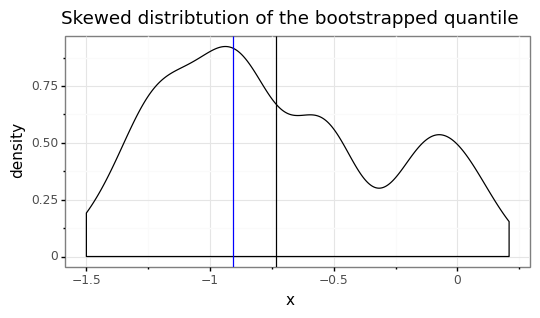

<ggplot: (-9223363284813487223)>

In [230]:
ex_stat = bs.apply(func=np.quantile, reps=nboot, extra_kwargs={'q':1-k}).flatten()
(ggplot(pd.DataFrame({'x':ex_stat}),aes(x='x')) + geom_density() + 
 theme_bw() + geom_vline(xintercept=np.quantile(phat_1,1-k),color='blue') +
 geom_vline(xintercept=np.mean(ex_stat),color='black') + 
 ggtitle('Skewed distribtution of the bootstrapped quantile\nBlue line is empirical quantile, black line is bootstrap mean'))

## Step 1: Calculate sample size needed to bound error to e%

Now that we have a threshold that will obtain the sensitivity bound $j\%$ of the time, we will want to determine how many additional samples to ensure that the sensivity is no worse than $(k-e)\%$. For example, if the target is 90% sensitivity, we may want to ensure (at 95% confidence), that we reject a null of sensitivity being $\leq 88\%$ (therefore $e=0.02$). This calculation can be calculated by appealing to the binomial confidence interval.

The null hypothesis we wish to reject is: $H_0: k_0 \leq k-e$ in favour of $H_A: k_0 < k-e$. The statistic and its critical value that will be calculated under the null is ($\hat{s}$) is the observed sensitivity):

$$
\begin{align*}
c_0 &= \frac{\hat{s} - k_0}{\sqrt{\frac{k_0(1-k_0)}{n}}} = \frac{\hat{s} - k_0}{\sigma_0} \sim N(0,1) \\
c^*_0(\alpha) &= k_0 + \sigma_0 \cdot \Phi^{-1}(1-\alpha) 
\end{align*}
$$

But since we are assuming that $\hat{s}$ is actually drawn from a binomial distribution with a mean of $k$, then the true distribution of the statistic $c_0$ will reject the null when:

$$
\begin{align*}
\hat{s} &> k_0 + \sigma_0 \cdot \Phi^{-1}_\alpha \\
\frac{\hat{s}-k}{\sigma_k} &> \frac{-e + \sigma_0 \cdot \Phi^{-1}_\alpha}{\sigma_k} \sim N(k, \sigma_k) \\
\frac{\hat{s}-k}{\sigma_k} &> \frac{- e \cdot \sqrt{n}}{\sqrt{k(1-k)}} + \frac{\sqrt{k_0(1-k_0)}}{\sqrt{k(1-k)}} \Phi^{-1}_\alpha
\end{align*}
$$

If we want reject the null $r\%$ of the time we simply need to use computationalm methods to find the $n$ which satisfies:

$$
n^* = \inf_n \hspace{2mm} \{ c(n) \geq r \}
$$

In [227]:
def norm_under_alt(k, e, n, alph=0.95):
  k0 = k - e
  sig_0 = np.sqrt(k0*(1-k0) / n)
  sig_k = np.sqrt(k*(1-k) / n)
  iPhi = stats.norm.ppf(alph)
  z = ( -e + sig_0 * iPhi) / sig_k
  return z

def power_under_alt(n, k, e, alph):
  r = 1-stats.norm.cdf(norm_under_alt(k=k, e=e, n=n, alph=alph))
  return r

def power_min(n, k, e, alph, target):
  res = (power_under_alt(n, k, e, alph) - target)**2
  return res

In [295]:
# Determine the sample size required for a sequence of k and e and r
k_seq = np.round(np.arange(0.9, 0.951, 0.01),2)
e_seq = np.round(np.arange(0.01, 0.051, 0.01),2)
r_seq = [0.80, 0.85, 0.90]

n_seq = np.arange(100,10000,100)

holder = []
for k in k_seq:
  for e in e_seq:
    for r in r_seq:
      tmp = pd.DataFrame({'n':n_seq, 'r':power_under_alt(n_seq,k,e,alph)})
      idx = ((tmp.r-r)**2).idxmin()
      n_seq2 = np.linspace(tmp.loc[idx-1].n, tmp.loc[idx+1].n, 50).astype(int)
      tmp = pd.DataFrame({'n':n_seq2, 'r':power_under_alt(n_seq2,k,e,alph)})
      n_star = int(tmp.loc[((tmp.r-r)**2).idxmin()].n)
      holder.append(pd.DataFrame({'n':n_star, 'k':k, 'e':e, 'r':r}, index=[0]))

dat_res = pd.concat(holder)
dat_res.head()

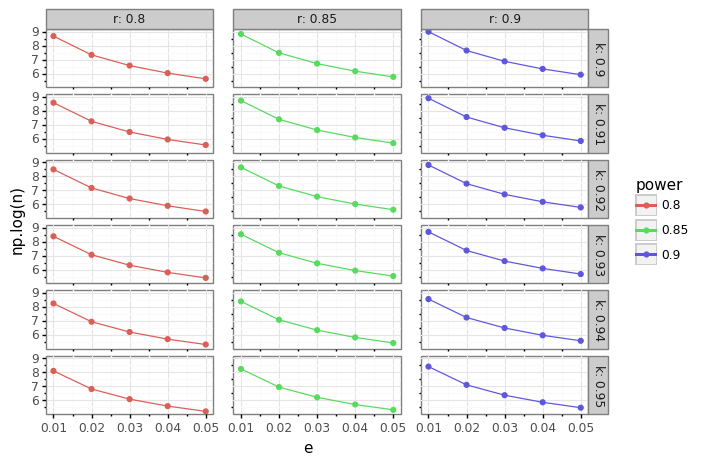

<ggplot: (8752039316656)>

In [301]:
plotnine.options.figure_size = (7,5)
(ggplot(dat_res, aes(x='e',y='np.log(n)',color='r.astype(str)')) + geom_point() + 
 geom_line() + facet_grid('k~r', labeller=label_both) + theme_bw() + 
 scale_color_discrete(name='power') + theme(panel_spacing_x=0.2))

### Check that a given power analysis will work

Assume We have k=0.95, e=0.05, alpha=0.95, and r=0.8 then:

In [321]:
k, e, alph, r = 0.95, 0.05, 0.95, 0.8
k0 = k - e
n_val_pos = int(np.ceil(minimize_scalar(power_min, bounds=(10,1000), args=(k, e, alph, r), method='bounded').x))
print('We need %i samples' % n_val_pos)

We need 184 samples


In [ ]:
np.random.seed(seed)

holder = np.zeros([nsim, 2])
for i in range(nsim):
  if (i + 1) % 100 == 0:    
    print('Iteration %i of %i' % (i+1,nsim))
  # A draw of the data from the universe of test sets
  phat_1_test = np.random.randn(n_test_pos)*sd_1 + mu_1
  # A draw of the data on the prospective validation set
  phat_1_val = np.random.randn(n_val_pos)*sd_1 + mu_1
  # Get the confidence intervals for the difference approaches
  bs = IIDBootstrap(a=phat_1_test)
  lb_bca = bs.conf_int(func=np.quantile, reps=nboot, method='bca', size=j, tail='lower', extra_kwargs={'q':1-k})[0,0]
  sens_val = np.mean(phat_1_val > lb_bca)
  pval = 1-stats.norm.cdf((sens_val - (k-e)) / np.sqrt(k0*(1-k0) / n_val_pos))
  holder[i] = np.array([sens_val, pval])

In [330]:
df_power = pd.DataFrame(holder,columns=['sens','pval'])
print('Reject the null %0.3f of the time\nAverage sensitivity: %0.3f' % 
      (np.mean(df_power.pval<1-alph), df_power.sens.mean()))

Reject the null 0.864 of the time
Average sensitivity: 0.965
